# CIS6800: Project 3: SOLO and FPN (Instance Segmentation)


### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* You may include any code used in previous projects. You may use ChatGPT, but you need to document how you use it.
* You should expect that a complete training session should last about 6 hours, so you should start part (b) as early as you can!
* To save on compute time, we debugging locally and using colab to train. Or use colab cpu instance for debugging
* We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.


The SOLO paper: https://arxiv.org/pdf/1912.04488.pdf


In [1]:
# download data, if the auto download faild, you can maunally download here:
# https://drive.google.com/drive/folders/17cT1ywZeKJ5l-FinBwpWv-EbvaMJ9mSa?usp=sharing

# !gdown --id 1JD3OaHpq_4KCb7ofcPMkknmdEXFHrCcn
# !gdown --id 1ssRA7yijGLFmJU-ac-lPyUOq7DYzTAS1
# !gdown --id 1Rpz-ZuQxDwvLyzc0FD9GZxAKlyka3VC5
# !gdown --id 1ouMFNT1thia8l6P5vcWCY-nweAexLDsB
# !pip install pytorch-lightning

/bin/bash: gdown: command not found
/bin/bash: gdown: command not found
/bin/bash: gdown: command not found
/bin/bash: gdown: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 2.3 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.1 MB/s eta 0:00:00a 0:00:01


## Code Structure
In this assignment, we are only providing the barest templates for your code structure. If you prefer, you can write and debug most of the components in a regular python and only use Jupyter to train. In this case, you might have several files that you import into this notebook, e.g.
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [3]:
try:
    import dataset
    import model
    import train
    import inference
except ModuleNotFoundError:
    pass

/home/yufeiyang/hw3_code/680hw3/lib/python3.12/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>  

In this project, you are tasked with implementing an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>  

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this.

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the image to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [2]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, masks, bounding_boxes = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times(256 + 2)$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels represent the $x$ and $y$ positional encoding. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 0$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.

#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

Please run the following cell for part A dataset and solo_head visualization

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from solo_head import *
from backbone import *

dataset build init is sucessful
full_size 3265
loader build is sucessful


d:\User\Desktop\machine_perception\P3 SOLO\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\User\Desktop\machine_perception\P3 SOLO\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
d:\User\Desktop\machine_perception\P3 SOLO\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
d:\User\Desktop\machine_perception\P3 SOLO\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_back

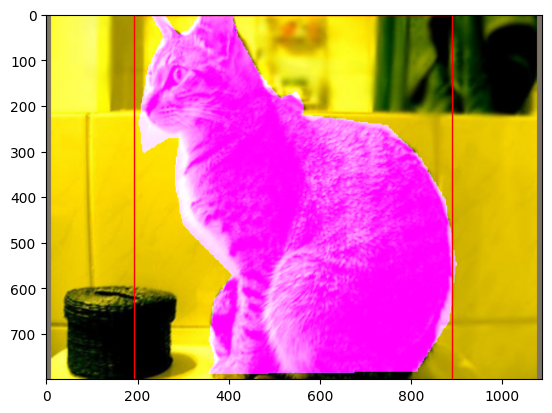

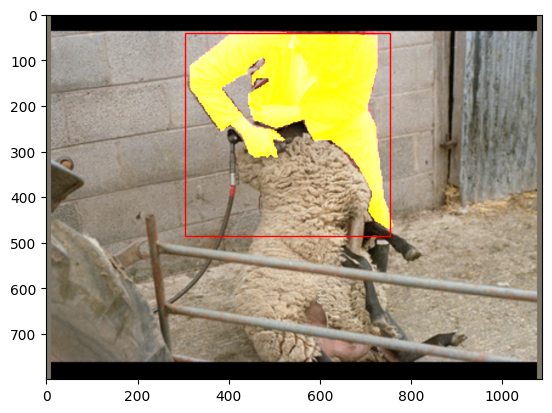

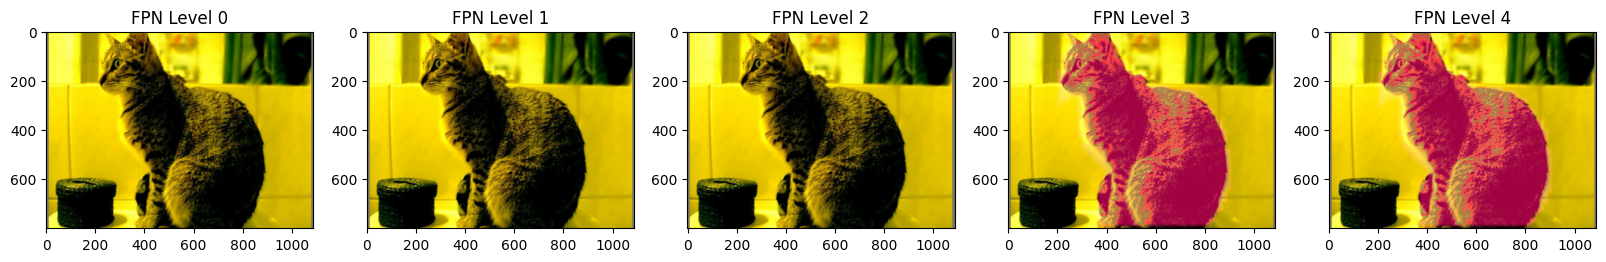

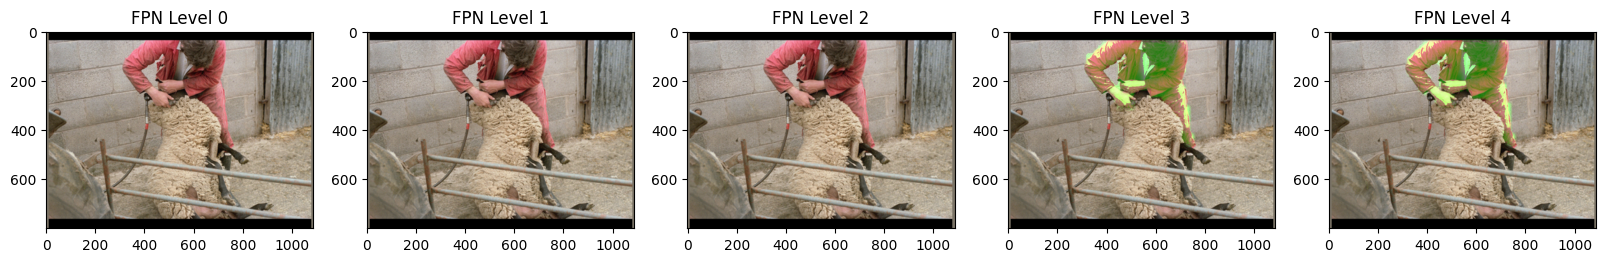

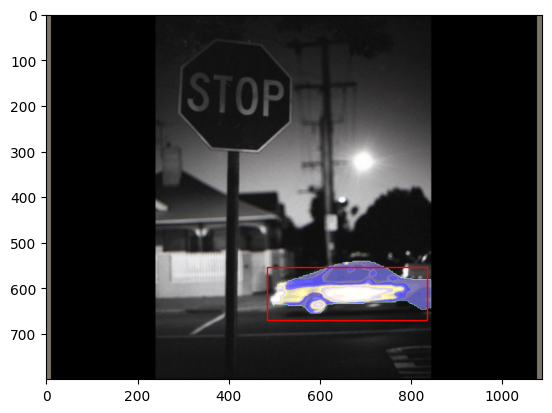

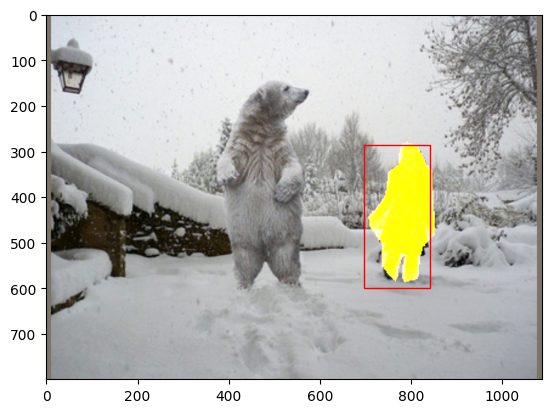

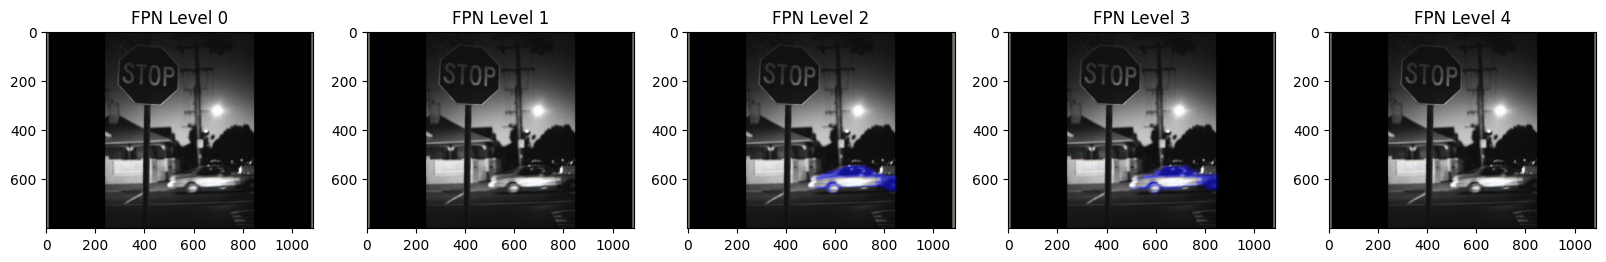

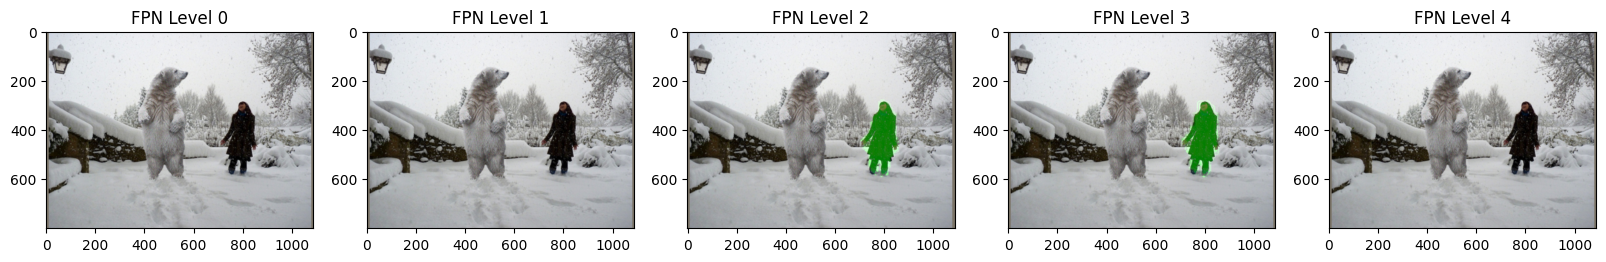

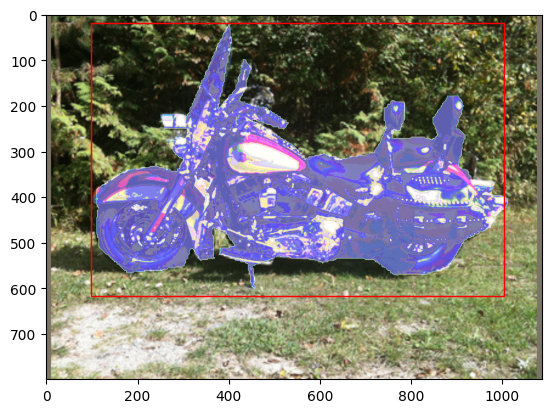

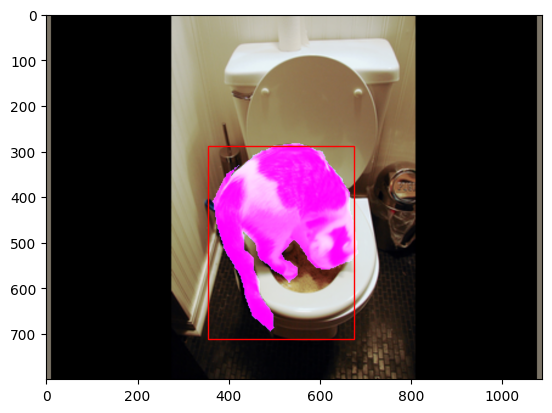

KeyboardInterrupt: 

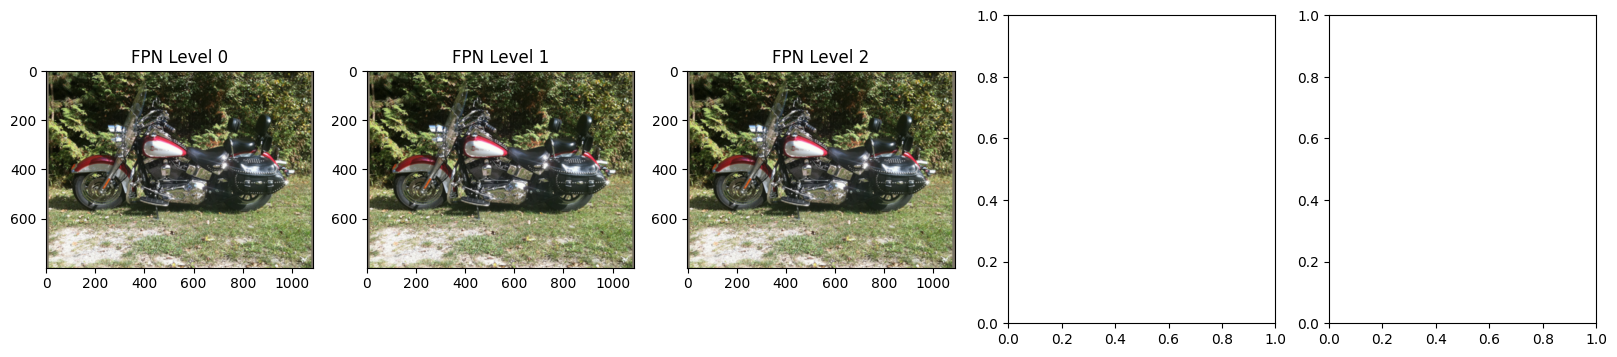

In [1]:
# Please run this file for part a

# file path and make a list
imgs_path = "./data/hw3_mycocodata_img_comp_zlib.h5"
masks_path = "./data/hw3_mycocodata_mask_comp_zlib.h5"
labels_path = "./data/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "./data/hw3_mycocodata_bboxes_comp_zlib.npy"
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)
print("dataset build init is sucessful")
## Visualize debugging
# --------------------------------------------
# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
print("full_size", full_size)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
# set seed
torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)
# push the randomized training data into the dataloader

batch_size = 2
train_build_loader = BuildDataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)
test_loader = test_build_loader.loader()
print("loader build is sucessful")
mask_color_list = ["jet", "ocean", "Spectral", "spring", "cool"]

resnet50_fpn = Resnet50Backbone()
solo_head = SOLOHead(
    num_classes=4
)  ## class number is 4, because consider the background as one category.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for iter, data in enumerate(train_loader, 0):
    img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]

    # check flag
    assert img.shape == (batch_size, 3, 800, 1088)
    assert len(mask_list) == batch_size

    label = [label_img.to(device) for label_img in label_list]
    mask = [mask_img.to(device) for mask_img in mask_list]
    bbox = [bbox_img.to(device) for bbox_img in bbox_list]

    # fpn is a dict
    backout = resnet50_fpn(img)
    fpn_feat_list = list(backout.values())

    # plot the origin img
    fig, ax = plt.subplots()
    for i in range(batch_size):
        ## TODO: plot images with annotations
        ax.clear()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        one_img = img[i].cpu().numpy().transpose(1, 2, 0)
        img_denormalized = one_img * std + mean
        img_clipped = np.clip(
            img_denormalized, 0, 1
        )  # Ensure values are in range [0, 1]
        img_binary = (img_clipped * 255).astype(np.uint8)

        height, width = img_clipped.shape[:2]
        mask_combined = np.zeros((height, width, 3), dtype=np.uint8)

        for j in range(len(mask[i])):
            current_mask = mask[i][j].cpu().numpy()
            cmap = plt.colormaps.get_cmap(
                mask_color_list[label[i][j].cpu().numpy() + 1]
            )
            colored_mask = cmap(current_mask)[:, :, :3]  # Get the RGB channels
            colored_mask_processed = (
                colored_mask[:, :, :3] * (current_mask > 0.5)[..., np.newaxis]
            )
            colored_mask_binary = (colored_mask_processed * 255).astype(np.uint8)
            mask_combined = np.maximum(mask_combined, colored_mask_binary)

        masked_img = np.bitwise_or(img_binary, mask_combined)
        plt.imshow(masked_img)

        for k in range(len(bbox[i])):
            x1, y1, x2, y2 = bbox[i][k].cpu().numpy()
            w = x2 - x1
            h = y2 - y1
            rect = patches.Rectangle(
                (x1, y1), w, h, linewidth=1, edgecolor="r", facecolor="none"
            )
            plt.gca().add_patch(rect)

        plt.savefig("./testfig/visualtrainset" + str(iter) + ".png")
        plt.gca().add_patch(rect).remove()
        plt.show()

        iter += 1

    cate_pred_list, ins_pred_list = solo_head.forward(fpn_feat_list, eval=False)
    ins_gts_list, ins_ind_gts_list, cate_gts_list = solo_head.target(
        ins_pred_list, bbox_list, label_list, mask_list
    )
    solo_head.PlotGT(
        ins_gts_list, ins_ind_gts_list, cate_gts_list, mask_color_list, img
    )

    if iter == 10:
        break

In [ ]:
import pytorch_lightning as pl

class SOLO(pl.LightningModule):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
    }

    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)

        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone
        ...

    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, S, S, C-1)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling
    def forward(self, images, eval=True):
        # you can modify this if you want to train the backbone
        feature_pyramid = [v.detach() for v in self.backbone(images).values()] # this has strides [4,8,16,32,64]
        ...

    # This function build the ground truth tensor for each batch in the training
    # Input:
    #     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
    #     labels:           list, len(batch_size), each (n_object, )
    #     masks:            list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    #     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
    #     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2*feature_h, 2*feature_w)
    #     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)
    #     / boolean array with positive mask predictions
    def generate_targets(self, bounding_boxes, labels, masks):
        ...

### Part A Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. Should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so.

## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.

In [ ]:
# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

In [2]:
# Training script
def train_main(train_dataset):
    batch_size = 2
    train_build_loader = BuildDataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    train_loader = train_build_loader.loader()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    solo_head = SOLOHead(num_classes=4).to(device)
    num_epochs = 1
    optimizer = torch.optim.SGD(solo_head.parameters(), lr=0.01/(16/batch_size), momentum=0.9, weight_decay=0.0001)

    resnet50_fpn = Resnet50Backbone()

    print("Training with: ", device)
    epoch = 0
    # Try loading checkpoint
    i = 0
    while True:
        PATH = f"checkpoints/checkpoint_epoch_{i}.pth"
        i += 1
        if os.path.exists(PATH):
            checkpoint = torch.load(PATH, weights_only=True)
            solo_head.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch = checkpoint['epoch']
            loss = checkpoint['loss']
            tl.append(loss)
            fl.append(checkpoint['focal_loss'])
            dl.append(checkpoint['dice_loss'])
        else:
            break

    tl = []
    fl = []
    dl = []

    for i in range(epoch, num_epochs, 1):
        print("For epoch number ", i)
        solo_head.train()
        running_loss = 0.0
        focal_loss = 0.0
        dice_loss = 0.0
        for iter, data in enumerate(train_loader, 0):
            img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
            backout = resnet50_fpn(img)
            fpn_feat_list = list(backout.values())
            cate_pred_list, ins_pred_list = solo_head.forward(fpn_feat_list, eval=False)
            ins_gts_list, ins_ind_gts_list, cate_gts_list = solo_head.target(ins_pred_list, bbox_list, label_list, mask_list)
            L_cate, L_mask, loss = solo_head.loss(cate_pred_list, ins_pred_list, ins_gts_list, ins_ind_gts_list, cate_gts_list)
            if i == 27 or i == 33:
                for group in optimizer.param_groups:
                    group['lr'] /= 10
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss =+ loss.item()
            dice_loss += L_mask.item()
            focal_loss += L_cate.item()
        tl.append(running_loss)
        fl.append(focal_loss)
        dl.append(dice_loss)
        # every epoch checkpoint should have a new file
        torch.save({
            'epoch': i,
            'model_state_dict': solo_head.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            "dice_loss": dice_loss,
            "focal_loss": focal_loss
            }, f"checkpoints/checkpoint_epoch_{i}.pth")
        
        print("Total loss is ", running_loss)
        print("Dice loss is ", dice_loss)
        print("Focal loss is ", focal_loss)
    return tl, fl, dl

imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)
print("dataset build init is sucessful")
## Visualize debugging
# --------------------------------------------
# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
print("full_size", full_size)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
# set seed
torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)
# push the randomized training data into the dataloader


total_loss, focal_loss, dice_loss = train_main(train_dataset)
plt.plot(total_loss)
plt.title("Training total loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.show()

plt.plot(focal_loss)
plt.title("Training focal loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Focal Loss")
plt.show()

plt.plot(dice_loss)
plt.title("Training dice loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Dice Loss")
plt.show()

dataset build init is sucessful
full_size 3265


d:\User\Desktop\machine_perception\P3 SOLO\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\User\Desktop\machine_perception\P3 SOLO\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
d:\User\Desktop\machine_perception\P3 SOLO\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
d:\User\Desktop\machine_perception\P3 SOLO\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_back

Training with:  cuda:0
For epoch number  0


d:\User\Desktop\machine_perception\P3 SOLO\solo_head.py:317: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  ins_gts = [torch.cat([ins_labels_level_img[ins_ind_labels_level_img, ...] for ins_labels_level_img, ins_ind_labels_level_img in zip(ins_labels_level, ins_ind_labels_level)], 0) for ins_labels_level, ins_ind_labels_level in zip(zip(*ins_gts_list), zip(*ins_ind_gts_list))]
d:\User\Desktop\machine_perception\P3 SOLO\solo_head.py:318: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  ins_preds = [torch.cat([ins_preds_level_img[ins_ind_labels_level_img, ...]for ins_preds_level_img, ins_ind_labels_level_img in zip(ins

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [10]:
# Inference script
def infer(test_dataset):
    batch_size = 4
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    solo_head = SOLOHead(num_classes=4).to(device)
    test_build_loader = BuildDataLoader(
        test_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    test_loader = test_build_loader.loader()
    # Load the model
    directory = "checkpoints"
    if len(os.listdir(directory)) > 0:
        last_checkpoint = os.listdir(directory)[-1]
        if last_checkpoint.endswith(".pth"):
            print("This is a valid checkpoint")
            PATH = f"{directory}/{last_checkpoint}"
            checkpoint = torch.load(PATH, weights_only=True)
            solo_head.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("There is not valid checkpoint")
    resnet50_fpn = Resnet50Backbone()
    # Inferencing
    for iter, data in enumerate(test_loader, 0):
        img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
        backout = resnet50_fpn(img)
        fpn_feat_list = list(backout.values())
        cate_pred_list, ins_pred_list = solo_head.forward(fpn_feat_list, eval=True)
        ins_gts_list, ins_ind_gts_list, cate_gts_list = solo_head.target(ins_pred_list, bbox_list, label_list, mask_list)
        # L_cate, L_mask, loss = solo_head.loss(cate_pred_list, ins_pred_list, ins_gts_list, ins_ind_gts_list, cate_gts_list)
        
        for i in range(batch_size):
            mask_color_list = ["jet", "ocean", "Spectral"]
            solo_head.PlotGT(ins_gts_list,ins_ind_gts_list,cate_gts_list,mask_color_list,img)
infer(test_dataset)

There is not valid checkpoint


/home/yufeiyang/hw3_code/680hw3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yufeiyang/hw3_code/680hw3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/yufeiyang/hw3_code/680hw3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/yufeiyang/hw3_code/680hw3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated

KeyboardInterrupt: 

### Training
#### Optimizer
The SGD optimizer with a weight decay of 1e-4 and a momentum of 0.9 is used. For a batch size of 16, an initial learning rate of 16 is used (this should be scaled appropriately for different batch sizes). You should train for 36 epochs, reducing the learning rate by a factor of 10 at epochs 27 and 33.

#### Data Augemnetation
To achieve better performance, you may wish to explore some data augmentation techniques. You should be able to achieve the necessary performance without any augmentation, however.

#### Checkpointing
Due to the long training time, we highly recommend that you set up regular checkpointing during your training in case your training gets interrupted (e.g. your colab session ending).

### Part B Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Final inference results such as figs. 11-14. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Training and validation loss curves. These should include the focal loss, dice loss, and total loss as seperate quantities.

In addition, you should include a discussion of any issues you encountered during this project and any changes you made to the siggested architecture. If you made any interesting observations or thoughts about potential improvements, you should also include them here.

* We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.
